# Movie Genre Prediction

In [40]:
import zipfile
import pandas as pd
import numpy as np
import json
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score


import text_processing as tp

### Purpose of script
This script uses the "The Movies Dataset" dataset to train a model that predicts a movie's genre given its title and description.
https://www.kaggle.com/rounakbanik/the-movies-dataset?select=movies_metadata.csv <br>

To retrain the model and reproduce the analysis, download and save the dataset in the data folder.

### Extract data

If you haven't already unzipped the downloaded file run the cell below to unzip.

In [4]:
MOVIE_DATA_DIR = './data/archive.zip'
TARGET_DIR = './data/'

# Check if zip file exists and extract if it does
try:
    with open(MOVIE_DATA_DIR) as f:
        with zipfile.ZipFile(MOVIE_DATA_DIR, 'r') as zip_ref:
            zip_ref.extractall(TARGET_DIR)
except IOError:
    print("File not accessible")

### Load Data

In [5]:
MOVIE_DATA_DIR = './data/movies_metadata.csv'

# Load the data into a DataFrame
raw_data = pd.read_csv(MOVIE_DATA_DIR, sep=',', error_bad_lines=False, index_col=False, dtype='unicode')

We will only keep the Genre, Title and Plot for each film

In [6]:
column_names = {'original_title': 'title',
                'overview': 'description',
                'genres': 'genres'}
movie_data = raw_data[column_names.keys()].copy()
# Rename columns
movie_data.rename(columns=column_names, inplace=True)
raw_records = len(movie_data)
print("There are {} records in the dataset.".format(raw_records))
# Display first 5 rows of dataset
movie_data.head()

There are 45466 records in the dataset.


,title,description,genres
0,Toy Story,"Led by Woody, Andy's toys live happily in his ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '..."
1,Jumanji,When siblings Judy and Peter discover an encha...,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
2,Grumpier Old Men,A family wedding reignites the ancient feud be...,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ..."
3,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."
4,Father of the Bride Part II,Just when George Banks has recovered from his ...,"[{'id': 35, 'name': 'Comedy'}]"


### Summarise dataset information

In [7]:
unique_movies = len(movie_data['title'].unique())
print("There are {} unique movies in the dataset.".format(unique_movies))

There are 43373 unique movies in the dataset.


There are titles that contain non-english characters that need to be removed:

In [8]:
movie_data = movie_data[movie_data['title'].map(lambda x: x.isascii())].reset_index(drop=True)
english_title_movies = len(movie_data)
print("{} movies were removed from the dataset.".format(raw_records-english_title_movies))

6177 movies were removed from the dataset.


We will also remove any movies without a description or title:

In [9]:
# Exclude any movies without title or description
movie_data = movie_data.loc[~movie_data['title'].isin([''])]
movie_data = movie_data.loc[~movie_data['title'].isin([''])]
complete_movies = len(movie_data)
print("{} movies were removed from the dataset.".format(english_title_movies-complete_movies))

0 movies were removed from the dataset.


### Data pre-processing

Make sure that all datatypes are consistent:

In [10]:
# Change Title and Description types to strings
movie_data['title'] = movie_data['title'].astype(str)
movie_data['description'] = movie_data['description'].astype(str)

We now need to convert the genres column to a list of genres

In [11]:
def extract_genres(row):
    genres_list = row.replace("'", '"')  # Replace single quotes to convert to json
    genres_json = json.loads(genres_list)  # Convert string to json
    genres = [gen_dict['name'] for gen_dict in genres_json]  # Extract all genres in dict
    return genres

# Reassign the genres column to a list of the movie genres
movie_data['genres'] = movie_data['genres'].apply(lambda x: extract_genres(x))

Let's exclude any movies that do not have any genres assigned to them.

In [12]:
movie_data = movie_data[movie_data['genres'].map(lambda x: len(x)) > 0]
records_with_genres = len(movie_data)
print("{} movies were removed from the dataset.".format(complete_movies-records_with_genres))

2062 movies were removed from the dataset.


There are movies with multiple same genres that need to be removed:

In [13]:
# Get a unique list of genres for each movie
movie_data['genres'] = movie_data['genres'].apply(lambda x: list(set(x)))

Now that we have the complete dataset let's explore how many genres are available. We will use NLTK which is a natural language processing tool:

In [14]:
# Create a list of all the available genres
all_genres = [item for sublist in movie_data['genres'].values for item in sublist]
unique_genres = len(set(all_genres))
print("There are {} unique genres in the dataset.".format(unique_genres))

# Get the term frequencies
all_genres = nltk.FreqDist(all_genres)
# Create a DataFrame for plotting
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})
# Before we plot let's normalise the results by the total number of movies
all_genres_df['Normalised Count'] = all_genres_df['Count'] / all_genres_df['Count'].sum()

There are 27 unique genres in the dataset.


Let's visualise the results:

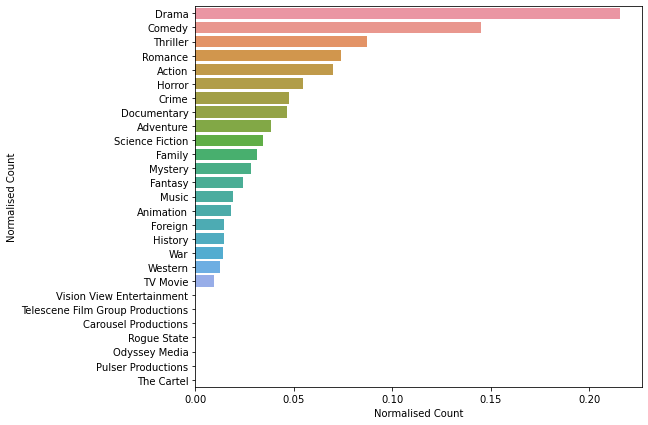

In [15]:
g = all_genres_df.nlargest(columns="Count", n=50) 
plt.figure(figsize=(8, 7)) 
ax = sns.barplot(data=g, x= "Normalised Count", y = "Genre") 
ax.set(ylabel = 'Normalised Count') 
plt.show()

We see that the last 7 genres do not fall under any specific category so we will replace them with "Other".

In [16]:
unknown_genres = ['Carousel Productions',
                  'Vision View Entertainment',
                  'Telescene Film Group Productions',
                  'Odyssey Media',
                  'Pulser Productions',
                  'Rogue State',
                  'The Cartel']

Let's loop though all our entries and remove these genres since their count is too small.

In [17]:
def remove_genres(row):
    '''
    Loops through all genres for each film and replaces with "Other"
    if genre is in the unknown_genres list.
    '''
    new_items = [x for x in row if x not in unknown_genres]
    
    return new_items

# Remove unknown genres from dataset
movie_data['genres'] = movie_data['genres'].apply(lambda x: remove_genres(x))  
# Reset df index
movie_data.reset_index(drop=True, inplace=True)

In [18]:
# Create a list of all the available genres
all_genres = [item for sublist in movie_data['genres'].values for item in sublist]
unique_genres = len(set(all_genres))
print("There are {} unique genres in the dataset.".format(unique_genres))

# Get the term frequencies
all_genres = nltk.FreqDist(all_genres)
# Create a DataFrame for plotting
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})
# Before we plot let's normalise the results by the total number of movies
all_genres_df['Normalised Count'] = all_genres_df['Count'] / all_genres_df['Count'].sum()

There are 20 unique genres in the dataset.


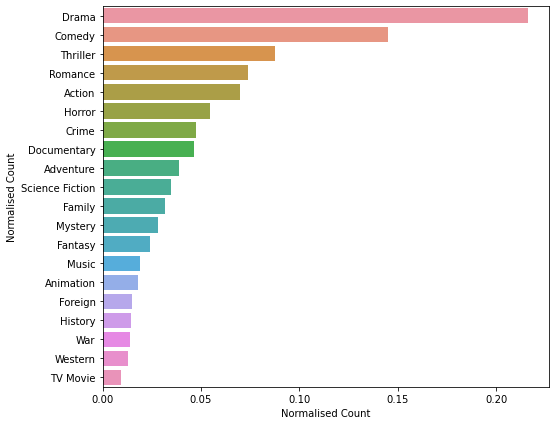

In [19]:
g = all_genres_df.nlargest(columns="Count", n=50) 
plt.figure(figsize=(8, 7)) 
ax = sns.barplot(data=g, x= "Normalised Count", y = "Genre") 
ax.set(ylabel = 'Normalised Count') 
plt.show()

The distribution of genres is skewed so when splitting the data for training we will try to stratify the dataset and potentially oversample the minority classes.

#### Text pre-processing

Before we train any models we will need to pre-process our text. <br>
We will follow these steps:
- Join the movie title to the movie description
- Remove whitespace, slashes, non-alphabetic charactes and convert text to lowecase
- Lemmatise the words
- Remove any stopwords

In [20]:
movie_data['text'] = \
    movie_data[['title', 'description']].apply(
        lambda row: tp.transform_text(row['title'], row['description']), axis=1)    

# Model training

### 1. Problem statement

This is a multi-class classification problem.

### 2. Features & Labels

We need to one-hot encode our labels.

In [21]:
multilabel_binarizer = MultiLabelBinarizer()  # Create a multi-class binariser
y = multilabel_binarizer.fit_transform(movie_data['genres'])  # Fit the binariser to the data and transform

### Create word embeddings

In [35]:
X = movie_data['text']

In [36]:
# Split data to train and test set
X_train, X_test, y_train, y_test = \
    train_test_split(X.values, y, test_size=0.20, random_state=42)

We will only vectorise the train and validation sets to avoid any data leakage:

In [24]:
# Create TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

In [25]:
# Split data to train and validation set
X_train, X_val, y_train, y_val = \
    train_test_split(X_train_tfidf, y_train, test_size=0.20, random_state=1)

In [26]:
# Get the number of classes to predict
classes = y.shape[-1]

### Train the model

#### 3. Model Definition

In [27]:
lr = LogisticRegression(solver='sag')
clf = OneVsRestClassifier(lr)

In [28]:
# Fit model on train data
clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(solver='sag'))

In [29]:
# make predictions for validation set
y_pred = clf.predict(X_val)

In [30]:
# evaluate performance
f1_score(y_val, y_pred, average="micro")

0.4560963645282608

### Evaluate the model

In [31]:
title = 'Avengers'
plot = 'Earths mightiest heroes must come together and learn to fight as a team if they are going to stop the mischievous Loki and his alien army from enslaving humanity.'

processed_data = tp.transform_text(title, plot)
print(processed_data)

avenger earth mightiest hero must come together learn fight team going stop mischievous loki alien army enslaving humanity


In [47]:
feature = tfidf_vectorizer.transform([processed_data])

In [48]:
y_hat = clf.predict(feature)

In [49]:
multilabel_binarizer.inverse_transform(y_hat)

[('Action', 'Science Fiction')]